<a href="https://colab.research.google.com/github/KsuZavyalova/vk_test_BDD/blob/main/test_vk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset

# Загрузка датасета
dataset = load_dataset("deepvk/ru-HNP")

# Просмотр структуры датасета
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['query', 'pos', 'neg'],
        num_rows: 100000
    })
    validation: Dataset({
        features: ['query', 'pos', 'neg'],
        num_rows: 590
    })
    test: Dataset({
        features: ['query', 'pos', 'neg'],
        num_rows: 2000
    })
})


In [4]:
# Посмотрим на структуру первого элемента датасета
print(dataset['train'][0])

# Посмотрим на ключи
print(dataset['train'].features)

{'query': 'С 1952 года после окончания Куйбышевского индустриального института им. В. В. Куйбышева работал в системе атомной промышленности СССР.', 'pos': ['После окончания Куйбышевского индустриального института им. В. В. Куйбышева он начал работать в системе атомной промышленности СССР с 1952 года.', 'С 1952 года после выпуска из Куйбышевского индустриального института им. В. В. Куйбышева он трудился в системе атомной промышленности СССР.', 'После окончания учебы в Куйбышевском индустриальном институте им. В. В. Куйбышева он поступил на работу в систему атомной промышленности СССР в 1952 году.', 'С 1952 года после получения диплома Куйбышевского индустриального института им. В. В. Куйбышева он приступил к работе в системе атомной промышленности СССР.', 'После выпуска из Куйбышевского индустриального института им. В. В. Куйбышева он стал работать в системе атомной промышленности СССР с 1952 года.'], 'neg': ['До 1952 года перед окончанием Куйбышевского индустриального института им. В. 

In [3]:
!pip install pymorphy2 nltk matplotlib

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Разработаем простую функцию для оценки схожести текстов. Начнем с простого подхода, основанного на общих словах.

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]


Results for Base Method:
Average positive score: 0.7947067490715807
Average negative score: -0.6914614904094972


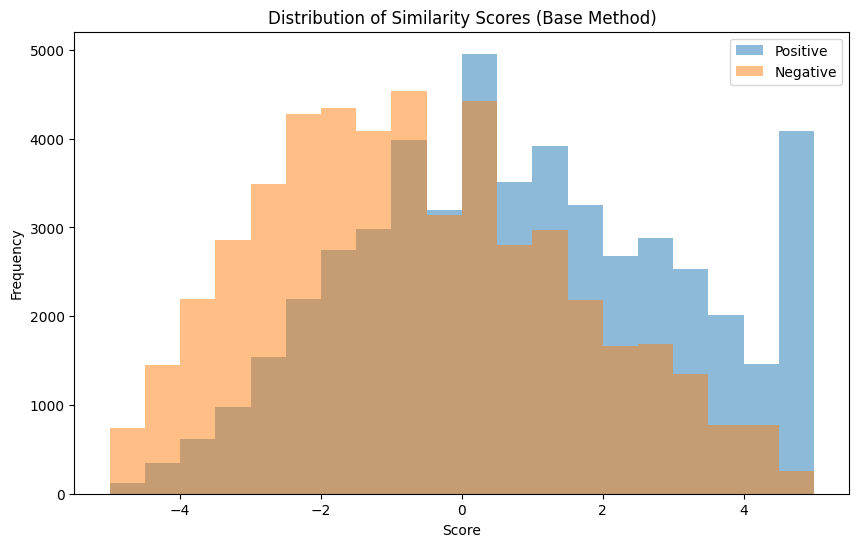

In [5]:
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pymorphy2
from nltk.stem.snowball import SnowballStemmer

# Инициализация лемматизатора и стеммера
morph = pymorphy2.MorphAnalyzer()
stemmer = SnowballStemmer("russian")

def preprocess_base(text):
    return re.findall(r'\w+', text.lower())

def similarity_score(text1, text2, preprocess_func):
    words1 = set(preprocess_func(text1))
    words2 = set(preprocess_func(text2))

    common_words = words1.intersection(words2)
    unique_words = words1.union(words2)

    similarity = len(common_words) / len(unique_words)

    return (similarity * 10) - 5

def process_item(item, preprocess_func):
    query = item['query']
    pos_scores = [similarity_score(query, pos, preprocess_func) for pos in item['pos']]
    neg_scores = [similarity_score(query, neg, preprocess_func) for neg in item['neg']]
    return {
        'query': query,
        'pos_scores': pos_scores,
        'neg_scores': neg_scores
    }

def evaluate_method(dataset, preprocess_func, method_name):
    results = dataset.select(range(10000)).map(lambda x: process_item(x, preprocess_func))

    pos_scores = [score for item in results for score in item['pos_scores']]
    neg_scores = [score for item in results for score in item['neg_scores']]

    print(f"\nResults for {method_name}:")
    print("Average positive score:", np.mean(pos_scores))
    print("Average negative score:", np.mean(neg_scores))

    plt.figure(figsize=(10, 6))
    plt.hist(pos_scores, bins=20, alpha=0.5, label='Positive')
    plt.hist(neg_scores, bins=20, alpha=0.5, label='Negative')
    plt.legend()
    plt.title(f'Distribution of Similarity Scores ({method_name})')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

    return results, pos_scores, neg_scores

# Проведем эксперименты
base_results, base_pos, base_neg = evaluate_method(dataset['train'], preprocess_base, "Base Method")

Ячейка ниже была использована для определения необходимого уровня предобработке текста.

In [6]:
def preprocess_lemma(text):
    words = re.findall(r'\w+', text.lower())
    return [morph.parse(word)[0].normal_form for word in words]

def preprocess_lemma_stem(text):
    words = re.findall(r'\w+', text.lower())
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return [stemmer.stem(word) for word in lemmas]

def similarity_score(text1, text2, preprocess_func):
    words1 = set(preprocess_func(text1))
    words2 = set(preprocess_func(text2))

    common_words = words1.intersection(words2)
    unique_words = words1.union(words2)

    similarity = len(common_words) / len(unique_words)

    return (similarity * 10) - 5

def process_item(item, preprocess_func):
    query = item['query']
    pos_scores = [similarity_score(query, pos, preprocess_func) for pos in item['pos']]
    neg_scores = [similarity_score(query, neg, preprocess_func) for neg in item['neg']]
    return {
        'query': query,
        'pos_scores': pos_scores,
        'neg_scores': neg_scores
    }

def evaluate_method(dataset, preprocess_func, method_name):
    results = dataset.select(range(50000)).map(lambda x: process_item(x, preprocess_func))

    pos_scores = [score for item in results for score in item['pos_scores']]
    neg_scores = [score for item in results for score in item['neg_scores']]

    print(f"\nResults for {method_name}:")
    print("Average positive score:", np.mean(pos_scores))
    print("Average negative score:", np.mean(neg_scores))

    plt.figure(figsize=(10, 6))
    plt.hist(pos_scores, bins=20, alpha=0.5, label='Positive')
    plt.hist(neg_scores, bins=20, alpha=0.5, label='Negative')
    plt.legend()
    plt.title(f'Distribution of Similarity Scores ({method_name})')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

    return results, pos_scores, neg_scores

# Проведем эксперименты
base_results, base_pos, base_neg = evaluate_method(dataset['train'], preprocess_base, "Base Method")
lemma_results, lemma_pos, lemma_neg = evaluate_method(dataset['train'], preprocess_lemma, "Lemmatization")
lemma_stem_results, lemma_stem_pos, lemma_stem_neg = evaluate_method(dataset['train'], preprocess_lemma_stem, "Lemmatization + Stemming")

# Анализ конкретных примеров, где оценки значительно изменились
def analyze_differences(base_results, new_results, method_name):
    significant_diff = []
    for base_item, new_item in zip(base_results, new_results):
        for i in range(len(base_item['pos_scores'])):
            diff = new_item['pos_scores'][i] - base_item['pos_scores'][i]
            if abs(diff) > 2:  # Считаем изменение значительным, если разница больше 2
                significant_diff.append((base_item['query'], base_item['pos'][i], base_item['pos_scores'][i], new_item['pos_scores'][i]))

    print(f"\nSignificant differences for {method_name}:")
    for query, pos, base_score, new_score in significant_diff[:5]:  # Выводим первые 5 примеров
        print(f"Query: {query}")
        print(f"Positive example: {pos}")
        print(f"Base score: {base_score:.2f}, New score: {new_score:.2f}")
        print()

analyze_differences(base_results, lemma_results, "Lemmatization")
analyze_differences(base_results, lemma_stem_results, "Lemmatization + Stemming")

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

KeyboardInterrupt: 

Лемматизация сама по себе дает значительное улучшение, а добавление стемминга дает лишь небольшое дополнительное улучшение. Учитывая, что стемминг может иногда приводить к потере семантических нюансов, можно рассмотреть использование только лемматизации.

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]


Results for TF-IDF with Lemmatization:
Average positive score: 3.2363361009121063
Average negative score: 2.0726124710747054


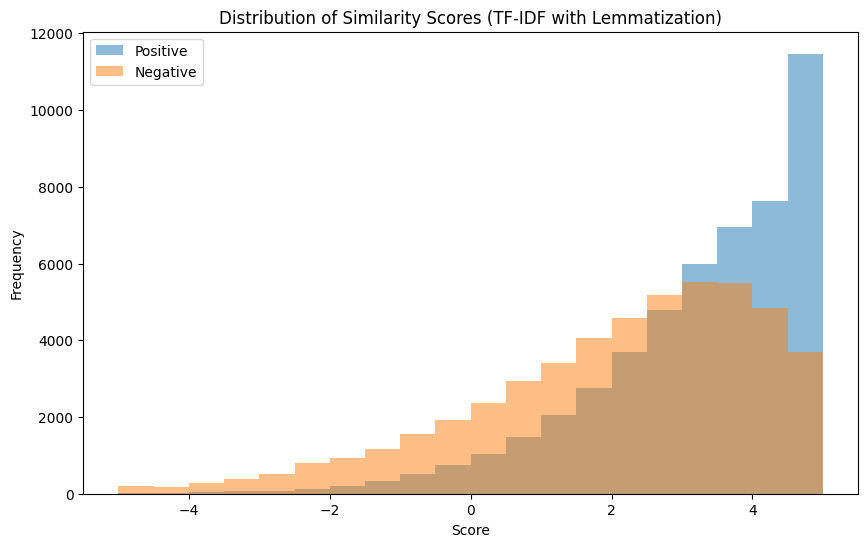


Significant differences for TF-IDF with Lemmatization:
Query: С 1952 года после окончания Куйбышевского индустриального института им. В. В. Куйбышева работал в системе атомной промышленности СССР.
Example: После окончания учебы в Куйбышевском индустриальном институте им. В. В. Куйбышева он поступил на работу в систему атомной промышленности СССР в 1952 году.
Base score: -1.54, New score: 3.77

Query: С 1952 года после окончания Куйбышевского индустриального института им. В. В. Куйбышева работал в системе атомной промышленности СССР.
Example: После окончания учебы в Куйбышевском индустриальном институте им. В. В. Куйбышева он не приступил к работе в системе атомной промышленности СССР в 1952 году.
Base score: -1.15, New score: 3.69

Query: С 1952 года после окончания Куйбышевского индустриального института им. В. В. Куйбышева работал в системе атомной промышленности СССР.
Example: До выпуска из Куйбышевского индустриального института им. В. В. Куйбышева он не трудился в системе атомной

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess_lemma(text):
    words = re.findall(r'\w+', text.lower())
    return ' '.join([morph.parse(word)[0].normal_form for word in words])

def similarity_score_tfidf(text1, text2, vectorizer):
    vector1 = vectorizer.transform([text1])
    vector2 = vectorizer.transform([text2])

    similarity = (vector1 * vector2.T).A[0][0]

    # Изменяем шкалу: теперь 0 соответствует -5, а 1 соответствует 5
    return similarity * 10 - 5

def process_item_tfidf(item, vectorizer):
    query = preprocess_lemma(item['query'])
    pos_scores = [similarity_score_tfidf(query, preprocess_lemma(pos), vectorizer) for pos in item['pos']]
    neg_scores = [similarity_score_tfidf(query, preprocess_lemma(neg), vectorizer) for neg in item['neg']]
    return {
        'query': query,
        'pos_scores': pos_scores,
        'neg_scores': neg_scores
    }

def evaluate_method_tfidf(dataset, method_name):
    # Подготовка данных для TF-IDF
    all_texts = [item['query'] for item in dataset] + \
                [pos for item in dataset for pos in item['pos']] + \
                [neg for item in dataset for neg in item['neg']]
    all_texts = [preprocess_lemma(text) for text in all_texts]

    # Создание и обучение TF-IDF векторизатора
    vectorizer = TfidfVectorizer()
    vectorizer.fit(all_texts)

    results = dataset.select(range(10000)).map(lambda x: process_item_tfidf(x, vectorizer))

    pos_scores = [score for item in results for score in item['pos_scores']]
    neg_scores = [score for item in results for score in item['neg_scores']]

    print(f"\nResults for {method_name}:")
    print("Average positive score:", np.mean(pos_scores))
    print("Average negative score:", np.mean(neg_scores))

    plt.figure(figsize=(10, 6))
    plt.hist(pos_scores, bins=20, alpha=0.5, label='Positive')
    plt.hist(neg_scores, bins=20, alpha=0.5, label='Negative')
    plt.legend()
    plt.title(f'Distribution of Similarity Scores ({method_name})')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

    return results, pos_scores, neg_scores

# Проведем эксперимент с TF-IDF и лемматизацией
tfidf_results, tfidf_pos, tfidf_neg = evaluate_method_tfidf(dataset['train'], "TF-IDF with Lemmatization")

# Анализ конкретных примеров
def analyze_differences_tfidf(base_results, new_results, method_name):
    significant_diff = []
    for base_item, new_item in zip(base_results, new_results):
        for i in range(len(base_item['pos_scores'])):
            base_score = base_item['pos_scores'][i]
            new_score = new_item['pos_scores'][i]
            if (base_score > 0 and new_score < 0) or (base_score < 0 and new_score > 0):
                significant_diff.append((base_item['query'], base_item['pos'][i], base_score, new_score))
        for i in range(len(base_item['neg_scores'])):
            base_score = base_item['neg_scores'][i]
            new_score = new_item['neg_scores'][i]
            if (base_score > 0 and new_score < 0) or (base_score < 0 and new_score > 0):
                significant_diff.append((base_item['query'], base_item['neg'][i], base_score, new_score))

    print(f"\nSignificant differences for {method_name}:")
    for query, example, base_score, new_score in significant_diff[:5]:
        print(f"Query: {query}")
        print(f"Example: {example}")
        print(f"Base score: {base_score:.2f}, New score: {new_score:.2f}")
        print()

analyze_differences_tfidf(base_results, tfidf_results, "TF-IDF with Lemmatization")

На данном этапе предобработки достаточно неплохо определяетя оценка позитивных текстов.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Создание обучающей выборки с метками
def create_labeled_dataset(dataset, base_results, tfidf_results):
    data = []
    for base_item, tfidf_item in zip(base_results, tfidf_results):
        query = base_item['query']
        # Позитивные пары
        for pos_text, base_score, tfidf_score in zip(dataset['pos'], base_item['pos_scores'], tfidf_item['pos_scores']):
            data.append({
                'query': query,
                'text': pos_text,
                'base_score': base_score,
                'tfidf_score': tfidf_score,
                'label': 1  # Позитивная пара
            })
        # Негативные пары
        for neg_text, base_score, tfidf_score in zip(dataset['neg'], base_item['neg_scores'], tfidf_item['neg_scores']):
            data.append({
                'query': query,
                'text': neg_text,
                'base_score': base_score,
                'tfidf_score': tfidf_score,
                'label': 0  # Негативная пара
            })
    return pd.DataFrame(data)

# Создание DataFrame с метками
labeled_df = create_labeled_dataset(dataset['train'], base_results, tfidf_results)

print("Размер обучающей выборки:", labeled_df.shape)
print(labeled_df.head())

# Извлечение признаков
# Объединим query и text для повторной векторизации
labeled_df['combined_text'] = labeled_df['query'] + ' ' + labeled_df['text']

# Векторизация с TF-IDF
vectorizer = TfidfVectorizer()
combined_tfidf = vectorizer.fit_transform(labeled_df['combined_text'])

# Дополнительные признаки
# Например, количество общих слов после лемматизации
def count_common_words(text1, text2):
    words1 = set(preprocess_lemma(text1).split())
    words2 = set(preprocess_lemma(text2).split())
    return len(words1.intersection(words2))

labeled_df['common_words'] = labeled_df.apply(lambda row: count_common_words(row['query'], row['text']), axis=1)
labeled_df['query_length'] = labeled_df['query'].apply(lambda x: len(preprocess_lemma(x).split()))
labeled_df['text_length'] = labeled_df['text'].apply(lambda x: len(preprocess_lemma(x).split()))
labeled_df['length_diff'] = labeled_df['query_length'] - labeled_df['text_length']

# Объединение всех признаков
from scipy.sparse import hstack

additional_features = labeled_df[['common_words', 'query_length', 'text_length', 'length_diff']].values
X = hstack([combined_tfidf, additional_features])
y = labeled_df['label'].values

# Обучение модели регрессии
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизация дополнительных признаков
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Обучение модели Ridge Regression
reg = Ridge(alpha=1.0)
reg.fit(X_train, y_train)

# Предсказание
y_pred = reg.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nОценка модели Ridge Regression:")
print(f"MSE: {mse:.4f}")
print(f"R^2: {r2:.4f}")

# Визуализация результатов
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Истинные метки')
plt.ylabel('Предсказанные значения')
plt.title('Истинные метки vs Предсказанные значения')
plt.plot([0,1], [0,1], 'r--')
plt.show()

# Улучшение модели (например, используя более сложные модели)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Обучение модели градиентного бустинга
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbc.fit(X_train, y_train)

# Предсказание
y_pred_gbc = gbc.predict(X_test)

# Оценка модели
print("\nОценка модели Gradient Boosting Classifier:")
print(classification_report(y_test, y_pred_gbc))
print("Матрица ошибок:")
print(confusion_matrix(y_test, y_pred_gbc))

# Визуализация матрицы ошибок
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_gbc), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок Gradient Boosting Classifier')
plt.show()